In [1]:
import numpy as np
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import pystan as ps
import arviz as av
import seaborn as sns
import pickle
import astropy.units as u
import astropy.constants as const

%matplotlib inline

In [2]:
data = ascii.read('/Users/samberek/Courses/1501project/pythoncode/NGC1407_GC.cat')

In [3]:
data.remove_row(348)
data.remove_row(343)
data.remove_row(264)
data.remove_row(13) 

In [4]:
los_vel = data['RV'] - 1779

In [5]:
def dist_calc(angrad):
    angle = angrad*u.arcmin
    radangle = angle.to(u.rad)
    convert = np.tan(radangle/2)*2*(26.8*u.Mpc)
    
    return (convert.to(u.kpc)).value

radius_kpc = np.array([dist_calc(i) for i in data['RAD']])

Data needs to be in a dictionary to be passed to Stan

In [6]:
standata = {
    'N': len(data),

    'r_obs': radius_kpc,
    'rv_obs': los_vel,
    'rv_err': data['RV_err'],
}

In [156]:
with open('single_hernquist.stan', 'r') as f:
    stancode = f.read()
    
sm = ps.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9522b5a33b94b2b513383324056d15aa NOW.


Initial values

In [157]:
def initial_values():
    return {
        
        #there needs to be a better prior here
        #'rho0': 1e6,
        'logM': 13,
        'a': 5,
        
#         'x': np.full(standata['N'], 10),
#         'v_yz': np.full(standata['N'], 10),
        
        'x': np.random.uniform(0,40, size=standata['N']),
        'v_yz': np.random.uniform(0,100, size=standata['N']),
        

        #'xv': np.random.uniform(min(standata['rv_obs']), max(standata['rv_obs']), size=int(standata['N']))
    }

In [176]:
adapt = {
    'adapt_delta': 0.95,
    'max_treedepth': 12
}

In [177]:
fit = sm.sampling(data=standata,
                  init=initial_values,
                  n_jobs = 1,
                  iter=2000, 
                  #chains=1, #1 for diagnostics
                  control = adapt, 
                  verbose=True
                 )

In [178]:
print(fit.stansummary())

Inference for Stan model: anon_model_9522b5a33b94b2b513383324056d15aa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM        13.2  2.2e-3    0.1  13.01  13.14   13.2  13.27   13.4   2062    1.0
a           5.26    0.06   2.76   0.39   3.22   5.14   7.19  10.94   1990    1.0
x[1]       24.22    0.32  18.94   0.83   9.15  20.26  34.89  71.05   3513    1.0
x[2]       24.01     0.3  18.02   0.95   9.76  20.38  34.51  66.65   3632    1.0
x[3]       24.03    0.27  17.44   1.02  10.27  20.74  34.58  65.02   4200    1.0
x[4]       23.59    0.29  18.03   0.99   9.31  19.82  33.98  66.79   3956    1.0
x[5]       24.25    0.29  18.17    1.2   9.82  20.38  34.56  67.88   4020    1.0
x[6]       23.58    0.28  17.81   0.77   9.41  19.66  34.66  65.82   3979    1.0
x[7]       23.66    0.28  17.46   0.84   9.49  20.35   34.8  64.02   3801    1.0
x

In [179]:
params = ["logM", "a"]

In [180]:
print(fit.stansummary(pars=params))

Inference for Stan model: anon_model_9522b5a33b94b2b513383324056d15aa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM   13.2  2.2e-3    0.1  13.01  13.14   13.2  13.27   13.4   2062    1.0
a      5.26    0.06   2.76   0.39   3.22   5.14   7.19  10.94   1990    1.0

Samples were drawn using NUTS at Thu Feb 25 11:50:33 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


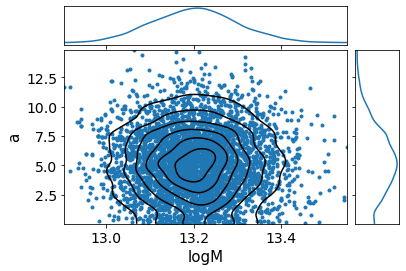

In [181]:
av.plot_pair(fit, var_names=params, kind=['kde', 'scatter'], marginals=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f955d87f190>,
      dtype=object)

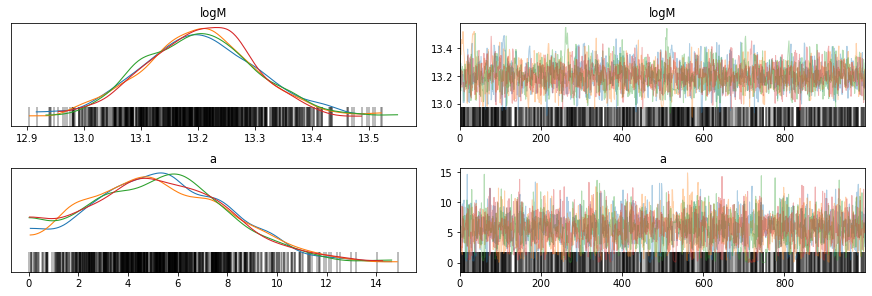

In [182]:
av.plot_trace(fit, var_names=params)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_traceplots3.pdf')

/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (370), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9570cd03a0>,
      dtype=object)

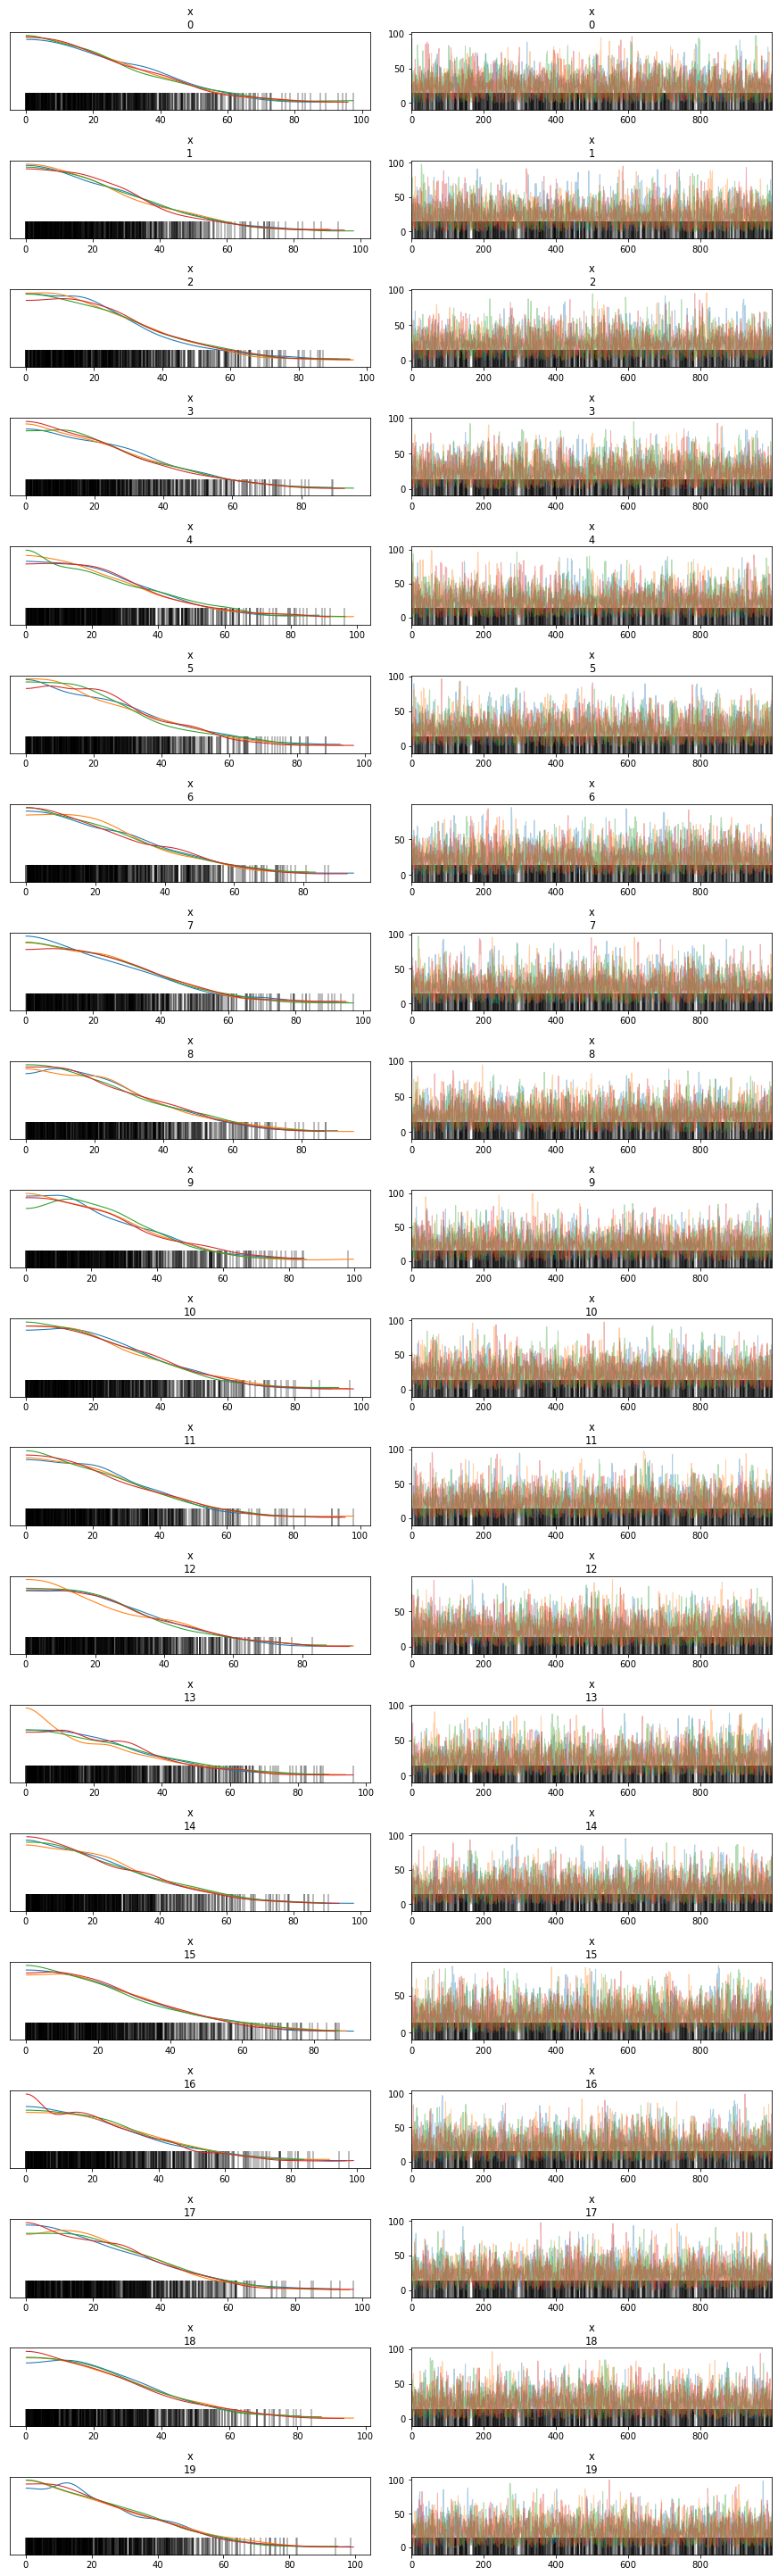

In [175]:
params2 = ["x"]

#av.plot_pair(fit, var_names=params2, kind=['kde', 'scatter'], marginals=True);
av.plot_trace(fit, var_names=params2)


/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (370), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f954f881130>,
      dtype=object)

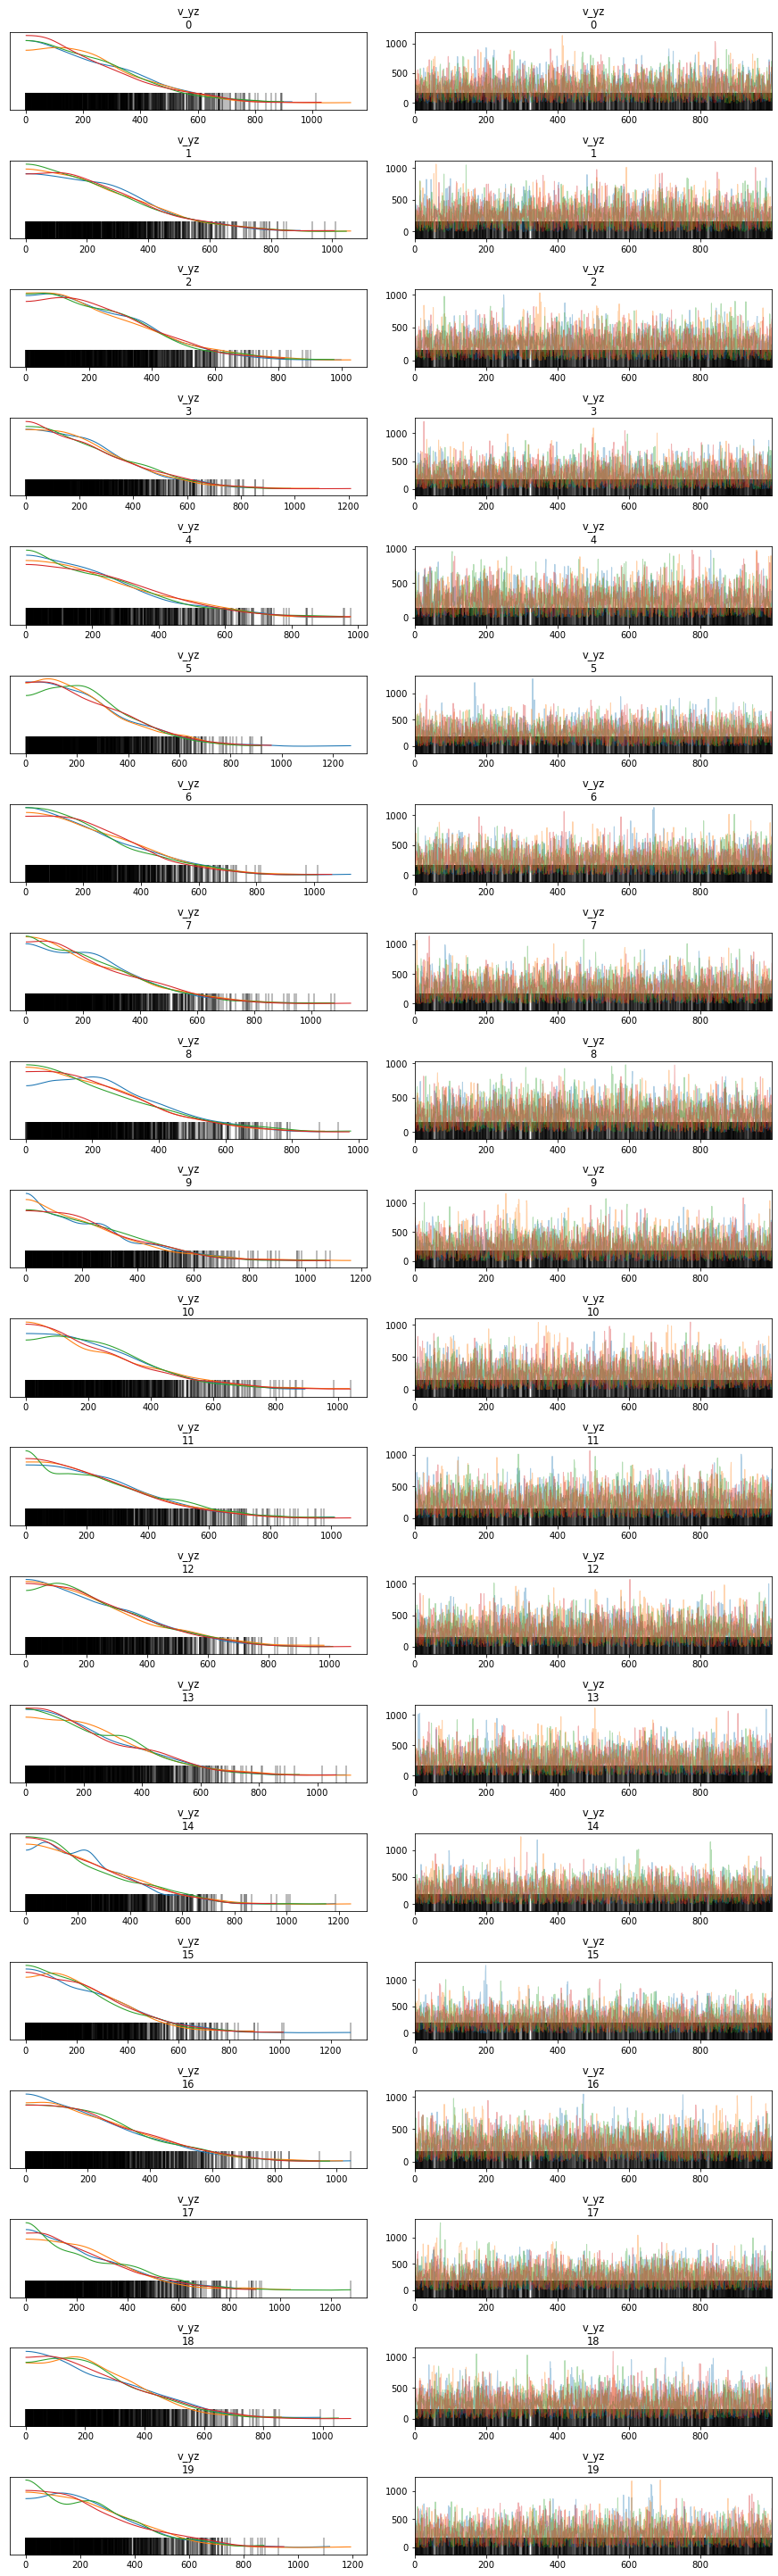

In [166]:
params3 = ["v_yz"]

#av.plot_pair(fit, var_names=params2, kind=['kde', 'scatter'], marginals=True);
av.plot_trace(fit, var_names=params3)


In [185]:
la = fit.extract()

In [186]:
def mass_enclosed(r, samples, full=False):
    mass = 10**samples['logM']
    a = samples['a']
    masses = mass*((r/a)**2/((1+(r/a))**2))


#     if full: 
#         return masses
    
    return np.quantile(masses, [0.025, 0.125, 0.25, 0.5, 0.75, 0.875, 0.975]) # quantiles that we want to get

In [187]:
print("Enclosed mass: %.4g" %mass_enclosed(300,la)[3])

Enclosed mass: 1.543e+13


(array([-5.0e+12,  0.0e+00,  5.0e+12,  1.0e+13,  1.5e+13,  2.0e+13,
         2.5e+13,  3.0e+13]),
 <a list of 8 Text major ticklabel objects>)

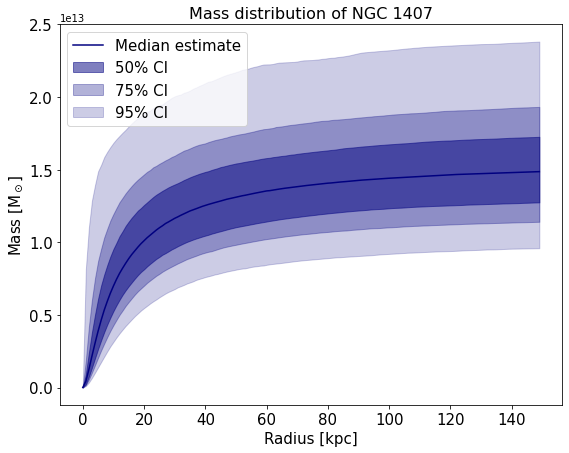

In [190]:
plt.figure(figsize=(9, 7))
radii = np.arange(150) # up to 250 kpc
masses = np.zeros((len(radii), 7))

for r in radii:
    masses[r] = mass_enclosed(r, la) # 251 x 7 array of various quantiles of masses at different radii
    
plt.plot(radii, masses[:, 3], c='navy', label='Median estimate')
plt.fill_between(radii, masses[:, 2], masses[:, 4], alpha=0.5, color='navy', label='50% CI')
plt.fill_between(radii, masses[:, 1], masses[:, 5], alpha=0.3, color='navy', label='75% CI')
plt.fill_between(radii, masses[:, 0], masses[:, 6], alpha=0.2, color='navy', label='95% CI')

plt.legend(loc='upper left', fontsize=15)
plt.title('Mass distribution of NGC 1407', fontsize=16)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel(r'Mass [M$_\odot$]', fontsize=15)
#plt.xlim(-1, 100)
#plt.yscale('log')
plt.xticks(size=15)
plt.yticks(size=15)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_log3.pdf')

In [ ]:
#I'll do M_200 by calculating the radius for which density is 200 times density of the universe

def calc_rvir(gamma, phi0, H=0.678e-3):
    return (gamma * phi0 / (100 * H**2)) ** (1 / 2 + gamma)

rvir = calc_rvir(
    np.median(la['p_gamma']), 
    np.median(la['p_phi0'])
) / 1000 # convert to kpc

plt.figure(figsize=(9, 7))

virial_mass = mass_at_radius(rvir, la, full=True)

sns.distplot(virial_mass) # density 
plt.axvline(np.median(virial_mass)) # draw a vertical line at the median mass
plt.annotate(rf"median: {np.median(virial_mass):.2f} $\times 10^{{12}}$ M$_\odot$", xy=(0.55, 0.7), xycoords='axes fraction', fontsize=15)

plt.title(rf'Distribution of M$_{{{200}}}$ = M(<{rvir:.0f} kpc)', fontsize=15)
plt.xlabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15);